# Case study: 3km long floating bridge

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyvista as pv
pv.set_jupyter_backend('trame')

## Create BEEF FE model

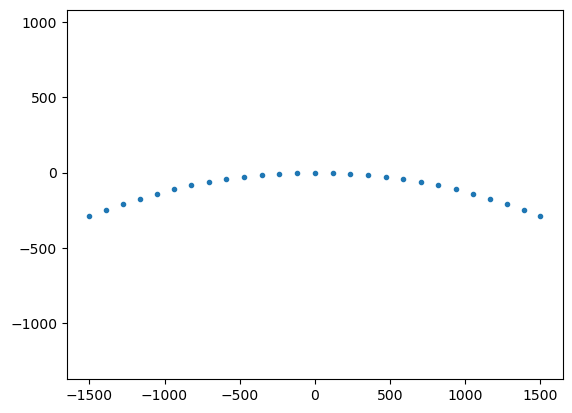

In [3]:
# Create BEEF model
# BEEF and KNUTILS are both available openly on GitHub
from beef import fe 
from beef.rotation import rodrot
from knutils import geometry
from beef.general import nodes_to_beam_element_matrix, blkdiag
from wawi import model as wmodel

span = 3000.0 # 3 km span
radius = 4000.0
n_pontoons = 25
h_girder = 12

angle_tot = geometry.arc_angle_from_length_and_radius(span, radius)
angle_start = np.pi/2 + angle_tot/2
angle_end = angle_start - angle_tot 
dangle = angle_tot/(n_pontoons+1)

points_angles = [angle_start - i*dangle for i in range(n_pontoons+2)]

x = np.cos(points_angles) * radius
y = np.sin(points_angles) * radius - radius
theta_pont = np.array(points_angles[1:-1])+np.pi/2

plt.plot(x, y, '.')
__ = plt.axis('equal')

In [5]:
# Establish elements
# Girder
girder_node_set = 1000
node_matrix_girder = np.vstack([girder_node_set+np.arange(1,len(x)+1), x, y, x*0+h_girder]).T
el_matrix_girder = nodes_to_beam_element_matrix(node_matrix_girder[:,0], 1000)
girder_xyz = node_matrix_girder[:,1:]

# Columns
column_el_set = 2000
node_matrix_ponts = node_matrix_girder[1:-1, :]*1
node_matrix_ponts[:, 0] = np.arange(1,len(node_matrix_ponts[:,0])+1, 1)
node_matrix_ponts[:,-1] = node_matrix_ponts[:,-1]*0

el_matrix_columns = np.vstack([[column_el_set+p, p, p+1+girder_node_set] for p in np.arange(1,n_pontoons+1)])

node_matrix = np.vstack([node_matrix_ponts, node_matrix_girder])
element_matrix = np.vstack([el_matrix_girder, el_matrix_columns])


In [7]:
# Define sections
E = 210e9
G = 0.5*E/(1+0.3)

section_girder = fe.Section(E=E, A=1.4, J=8.4, I_y=3.5, I_z=80.8, m=17.5e3, poisson=0.3, e3=[0,0,1])
section_columns = fe.Section(E=E, A=293.769e9/E, J=4.628e12/E, poisson=0.3, I_z=2.566e12/E, I_y=2.566e12/E, m=12.95e3)

In [9]:
# Add CustomMatrix spring stiffnesses and mass to represent restoring stiffness of pontoons and structural mass
# Stiffness
Kz = 7458e3
Krx = 1.466e9
Kry = 33.98e6

K = np.array([[0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,Kz,0,0,0],
              [0,0,0,Krx,0,0],
              [0,0,0,0,Kry,0],
              [0,0,0,0,0,0]])

# Mass
M0 = 1000e3
Mxx = 240e6
Myy = 31.36e6
Mzz = 249.6e6
M = np.array([[M0, 0,    0,   0,   0,    0],
             [0,     M0,  0,  0,   0,   0],
             [0,     0,   M0, 0,   0,   0],
             [0,     0,    0, Mxx, 0,   0],
             [0,     0,    0, 0, Myy,   0],
             [0,     0,    0, 0, 0,   Mzz]])

springs = []
masses = []

for p_ix, th in enumerate(theta_pont):
    T = blkdiag(rodrot(th), 2)
    springs.append(fe.CustomMatrix('k', p_ix+1, K, tmat = T, name=f'Stiffness P{p_ix+1}'))
    masses.append(fe.CustomMatrix('m', p_ix+1, M, tmat = T, name=f'Mass P{p_ix+1}'))

features = springs + masses

In [11]:
# Create support constraints
constraints = [fe.Constraint([int(node_matrix_girder[-1,0]), int(node_matrix_girder[0,0])], dofs='all')]

In [13]:
part = fe.Part(node_matrix, element_matrix, sections=[section_girder]*el_matrix_girder.shape[0]+ 
                                                      [section_columns]*el_matrix_columns.shape[0],
                  features=features, constraints=constraints)

# Assign e2 for columns (different for each one)
for ix,th in enumerate(theta_pont):
    el = part.get_element(column_el_set + ix + 1)
    el.assign_e2(np.array([np.sin(th), -np.cos(th), 0]))

part.update_all_geometry()
part.plot(tmat_on=['undeformed'])

Widget(value='<iframe src="http://localhost:60540/index.html?ui=P_0x1f8ca549af0_0&reconnect=auto" class="pyvis…

In [15]:
# Create analysis object and run modal analysis
analysis = fe.Analysis(part) 
lambd, phi = analysis.run_eig()
phi_forces, forces_xyz = fe.Results.get_modal_forces(analysis, phi, elements=el_matrix_girder[:,0], 
                                                  return_pos=True) # establish phi forces
k = np.diag(phi.T @ part.k @ phi)

pontoon_dof_ix = part.get_global_dofs(node_matrix_ponts[:,0])
phi_hydro = phi[pontoon_dof_ix, :]
girder_dof_ixs = part.get_global_dofs(node_matrix_girder[:,0])
phi_girder = phi[girder_dof_ixs, :]

Post processing:   0%|          | 0/299 [00:00<?, ?it/s]

In [17]:
# Plot mode 1
analysis.eldef.deform(phi[:,0]*300)
analysis.eldef.plot(plot_states=['undeformed', 'deformed'])
print(f'T1 = {2*np.pi/np.abs(lambd[0]):.1f} s')

Widget(value='<iframe src="http://localhost:60540/index.html?ui=P_0x1f8d7d45d60_1&reconnect=auto" class="pyvis…

T1 = 39.6 s


## Create WAWI model

In [19]:
# Load pontoon type
P = np.load('L53D53.npz')
pontoon_type = wmodel.PontoonType.from_numeric(A=P['M'], B=P['C'], 
                         omega=P['omega'], Q=P['Q'], theta=P['theta_Q'], omegaQ=P['omega_Q'], label='Pontoon', 
                         stl_path='pontoon.stl')   

# Create WAWI model
pontoons = [wmodel.Pontoon(part.get_node(ix+1), pontoon_type, rotation=th, label=f'P{ix+1}') for ix, th in enumerate(theta_pont)]

# Establish subobjects
hydro = wmodel.Hydro(pontoons)
modal_dry = wmodel.ModalDry(dict(full=phi, hydro=phi_hydro, girder=phi_girder, girder_forces=phi_forces), 
                            phi_x=dict(girder_forces=forces_xyz, girder=girder_xyz), omega_n=np.abs(lambd), m=None, k=k, xi0=0.3e-2)

aero_section = wmodel.AeroSection(D=4.5, B=25.0, Cd=0.68, dCd=-1.0, Cl=-0.39, dCl=4.0, Cm=-0.07, dCm=1.0)
windstate = wmodel.Windstate(28.5, 270, Iu=0.136, Iw=0.072, Au=6.8, Aw=9.4, Cuy=10.0, Cwy=6.5, Lux=115, Lwx=9.58)
aero = wmodel.Aero(sections=dict(girder=aero_section), 
                   element_assignments=dict(girder=el_matrix_girder[:,0]), windstate=windstate)

# Place in model object and connect to beef eldef
model = wmodel.Model(eldef=part, hydro=hydro, aero=aero, modal_dry=modal_dry)
model.n_modes = 100
model.connect_eldef()

In [21]:
pontoons_dict= dict()
for pontoon in pontoons:
    pontoons_dict[pontoon.label] = dict(coordinates=list(pontoon.node.coordinates), pontoon_type='ptype_1',
                                           rotation=pontoon.rotation, node=pontoon.node.label)

In [23]:
import json
with open('pontoon_out.json', 'w') as f:
    json.dump(pontoons_dict, f, indent=2)

In [27]:
def tl(arr):
    lo = list(arr)
    for ix,li in enumerate(lo):
        lo[ix] = list(li)

    return lo

modal_dict = dict(phi=dict(full=tl(phi), hydro=tl(phi_hydro), girder=tl(phi_girder), girder_forces=tl(phi_forces)),
                  phi_x=dict(girder_forces=tl(forces_xyz), girder=tl(girder_xyz)),
                   xi0=0.3e-2, m=list(modal_dry.m), k=list(modal_dry.k), local=False,
                  m_min=0.0)
with open('modal_out.json', 'w') as f:
    json.dump(modal_dict, f, indent=2)          

In [29]:
pl = model.plot_mode(0, use_dry=True, show=False, title='', plot_water=True)
pl.reset_camera()
pl.camera.azimuth = 0
pl.camera.elevation = -10  
pl.camera.zoom(4.7)

from wawi.plot import save_plot
save_plot(pl, 'test.png', w=2000*1.5, h=1300*1.5)

## Export WAWI model

In [31]:
model.to_wwi('model_curved.wwi')